# Heterogeneous flow

The best way to run `foxes` calculations on heterogeneous background flow fields is by providing them in `netCDF` format. The following coordinates are supported (can be `None` if not present):

- A state coordinate, e.g. `Time` (expected by default) or `state`, or similar
- A height coordinate, e.g. `height` (expected by default) or `h`, or similar
- A `y` coordinate, e.g. `UTMY` (expected by default) or `y`, or similar
- A `x` coordinate, e.g. `UTMX` (expected by default) or `x`, or similar

The file may contain any kind of `foxes` variables as data fields, e.g.:

- Wind speed data, e.g. `WS` (expected by default, if claimed as output variable), `ws` or similar
- Wind direction data, e.g. `WD` (expected by default, if claimed as output variable), `wd` or similar
- Turbulence intensity data, e.g. `TI` (expected by default, if claimed as output variable), `ti` or similar
- Air density data, e.g. `RHO` (expected by default, if claimed as output variable), `rho` or similar

All data must depend on the state coordinate, and may depend on the others.

These are the required imports for this example:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import foxes
import foxes.variables as FV

One very simple example for `netCDF` type data is provided in the static data, under the name `wind_rotation.nc`. It contains two states, two heights, and simple 2 x 2 horizontal data that describes identical wind speeds at all four corner points associated with different wind direction values. It can be loaded as follows:

In [2]:
states = foxes.input.states.FieldDataNC(
    data_source="wind_rotation.nc",
    states_coord="state",
    x_coord="x",
    y_coord="y",
    h_coord="h",
    time_format=None,
    output_vars=[FV.WS, FV.WD, FV.TI, FV.RHO],
    var2ncvar={FV.WS: "ws", FV.WD: "wd"},
    fixed_vars={FV.RHO: 1.225, FV.TI: 0.1},
    load_mode="preload",
    bounds_error=False,
    bounds_extra_space=1000,
)

The `bounds_extra_space` parameter is here set to 1000 meters. Alternatively, distances can be specified as multiples of the rotor diameter as string, e.g., `2D`. If not `None` this cuts the input data spatially to the specified extension of the wind farm boundary area.

Note that it is recommended that the `states` object should be created outside the `Engine` context when working with NetCFD input.

Now back to our example. Let's place a simple 3 x 3 grid wind farm inside the data domain, which is a rectangle between `(0, 0)` and `(2500, 2500)`:

In [3]:
farm = foxes.WindFarm()
foxes.input.farm_layout.add_grid(
    farm,
    xy_base=np.array([500.0, 500.0]),
    step_vectors=np.array([[500.0, 0], [0, 500.0]]),
    steps=(3, 3),
    turbine_models=["NREL5MW"],
    verbosity=0,
)

The streamline following wakes are realized by selecting a `wake frame` that is an instance of `foxes.models.wake_frames.Streamlines`, e.g. the model `streamlines_100` in the model book. This model has a streamline step size of 100 m:

In [4]:
algo = foxes.algorithms.Downwind(
    farm,
    states,
    rotor_model="grid16",
    wake_models=["Jensen_linear_k007"],
    wake_frame="streamlines_100",
    verbosity=0,
)

We run the algorithm, once explicitely for calculating the wind farm data, and once implicitely when creating horizontal flow plots:

Selecting 'DefaultEngine(n_procs=16, chunk_size_states=None, chunk_size_points=None)'


DefaultEngine: Selecting engine 'single'
SingleChunkEngine: Calculating 2 states for 9 turbines
SingleChunkEngine: Running single chunk calculation for 2 states
                       WD  AMB_REWS      REWS        AMB_P            P
state turbine                                                          
0     0        201.161371  7.491089  7.491089  1474.211367  1474.211367
      1        208.049066  7.673386  7.673386  1580.523022  1580.523022
      2        214.528483  7.960601  7.960601  1748.171047  1748.171047
      3        218.247780  6.867297  6.867297  1127.597810  1127.597810
      4        222.303121  7.283373  7.283373  1352.715530  1352.715530
      5        225.904246  7.731909  7.731909  1614.607085  1614.607085
      6        236.756149  6.932726  6.932726  1156.958672  1156.958672
      7        237.144203  7.375640  7.375640  1406.547918  1406.547918
      8        237.488279  7.818854  7.818854  1665.347000  1665.347000
1     0         20.313664  6.703701  6.703701  

ProcessEngine: Computing 32 chunks using 16 processes


  0%|                                                                                                   | 0/32 [00:00<?, ?it/s]

  3%|██▊                                                                                        | 1/32 [00:01<00:36,  1.17s/it]

 16%|██████████████▏                                                                            | 5/32 [00:01<00:05,  4.66it/s]

 47%|██████████████████████████████████████████▏                                               | 15/32 [00:01<00:01, 15.05it/s]

 78%|██████████████████████████████████████████████████████████████████████▎                   | 25/32 [00:02<00:00, 17.02it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 15.00it/s]

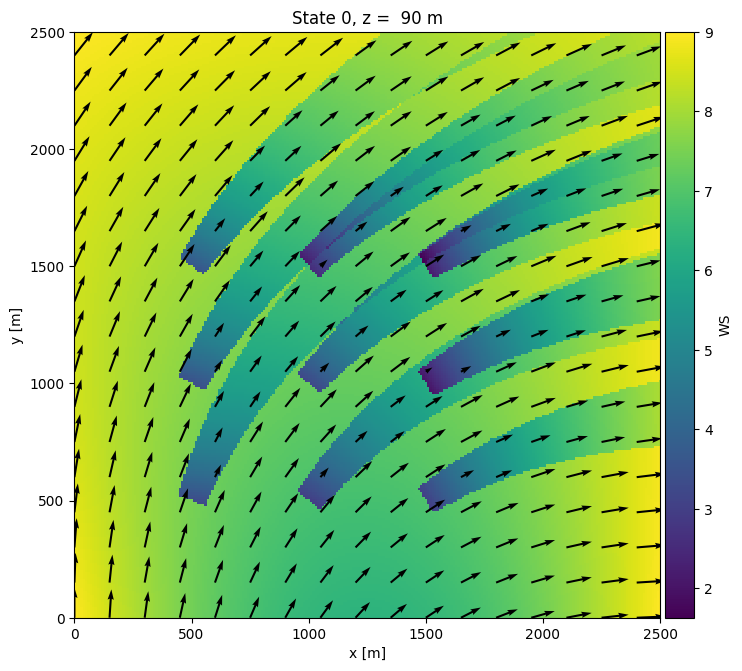

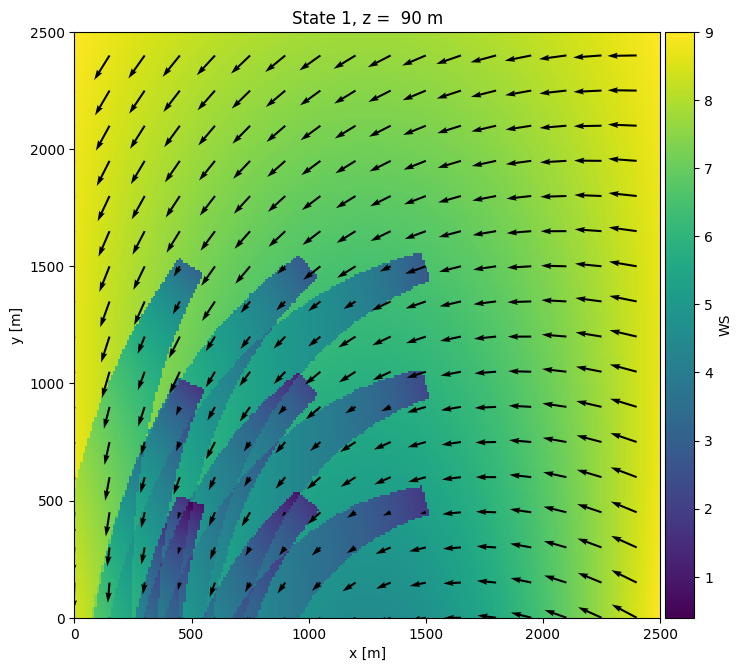

In [5]:
farm_results = algo.calc_farm()

fr = farm_results.to_dataframe()
print(fr[[FV.WD, FV.AMB_REWS, FV.REWS, FV.AMB_P, FV.P]])

o = foxes.output.FlowPlots2D(algo, farm_results)
for fig in o.gen_states_fig_xy(
    FV.WS,
    resolution=10,
    figsize=(8, 8),
    quiver_pars=dict(angles="xy", scale_units="xy", scale=0.07),
    quiver_n=15,
    xmin=0,
    xmax=2500,
    ymin=0,
    ymax=2500,
):
    plt.show()
    plt.close(fig)